## Setting

In [1]:
using NeuralVerification, LazySets, Plots
using NeuralVerification: ReLU, Id

We consider a small network that encodes the function 
    
$$
f(x) = 24~\max(x + 1.5, 0) + 18.5
$$

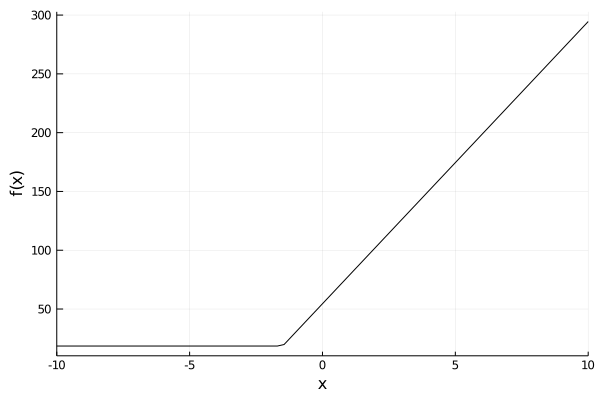

In [2]:
f(x) = 24*max(x + 1.5, 0) + 18.5

fig = plot()
plot!(fig, f, xlims=(-10.0, 10.0), xlab="x", ylab="f(x)", lab="", color=:black)

In [3]:
file = "small_nnet.nnet"
small_nnet = read_nnet(file, last_layer_activation = ReLU())

Network(NeuralVerification.Layer[NeuralVerification.Layer{ReLU,Float64}([1.0; 1.0], [1.5, 1.5], ReLU()), NeuralVerification.Layer{ReLU,Float64}([2.0 2.0; 2.0 2.0], [2.5, 2.5], ReLU()), NeuralVerification.Layer{ReLU,Float64}([3.0 3.0], [3.5], ReLU())])

In [4]:
length(small_nnet.layers)

3

In [5]:
dump(small_nnet)

Network
  layers: Array{NeuralVerification.Layer}((3,))
    1: NeuralVerification.Layer{ReLU,Float64}
      weights: Array{Float64}((2, 1)) [1.0; 1.0]
      bias: Array{Float64}((2,)) [1.5, 1.5]
      activation: ReLU ReLU()
    2: NeuralVerification.Layer{ReLU,Float64}
      weights: Array{Float64}((2, 2)) [2.0 2.0; 2.0 2.0]
      bias: Array{Float64}((2,)) [2.5, 2.5]
      activation: ReLU ReLU()
    3: NeuralVerification.Layer{ReLU,Float64}
      weights: Array{Float64}((1, 2)) [3.0 3.0]
      bias: Array{Float64}((1,)) [3.5]
      activation: ReLU ReLU()


The network has three layers and one output.

With the following fucntion we propagate an initial set $X_0 \subseteq \mathbb{R}$ through the neural network `network`. To simplify the discussion we consider that all layers use the ReLU activation function.

In [6]:
activate(Y, ::ReLU) = overapproximate(Rectification(concretize(Y)), Zonotope)
activate(Y, ::Id) = concretize(Y)

function forward_propagate(network, X0)
    Y = copy(X0)
    for Li in network.layers
        Wi, bi = Li.weights, Li.bias
        Y = Wi * Y + bi
        Y = activate(Y, Li.activation)
    end
    return Y
end

forward_propagate (generic function with 1 method)

## Solution for singleton values

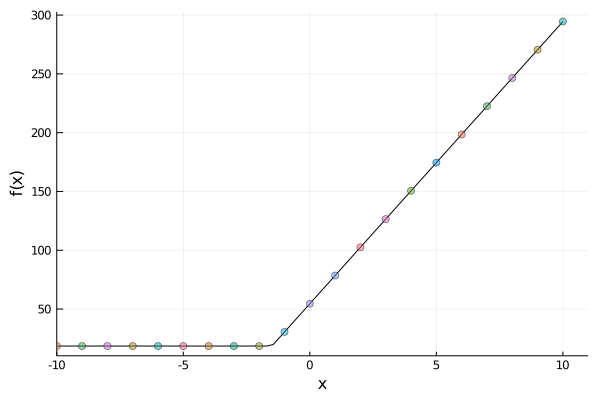

In [7]:
xin = [Singleton([α]) for α in -10:1.0:10]
xout = [forward_propagate(small_nnet, x) for x in xin]
plot!(deepcopy(fig), [xi × xo for (xi, xo) in zip(xin, xout)])

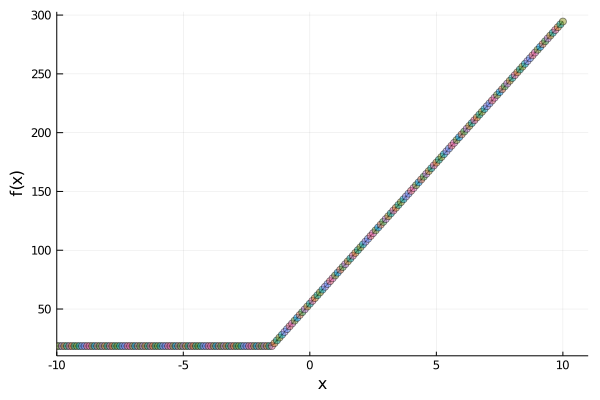

In [8]:
xin = [Singleton([α]) for α in -10:0.1:10]
xout = [forward_propagate(small_nnet, x) for x in xin]
plot!(deepcopy(fig), [xi × xo for (xi, xo) in zip(xin, xout)])

## Solution for initial sets

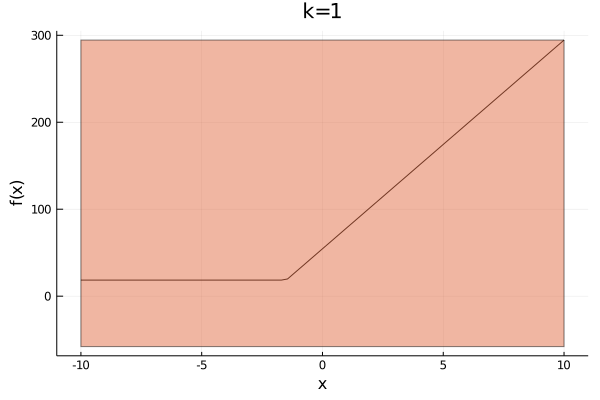

In [9]:
k = 1
xin = split(Interval(-10, 10), [k])
xout = [forward_propagate(small_nnet, x) for x in xin]
plot!(deepcopy(fig), [xi × xo for (xi, xo) in zip(xin, xout)], title="k=$k")

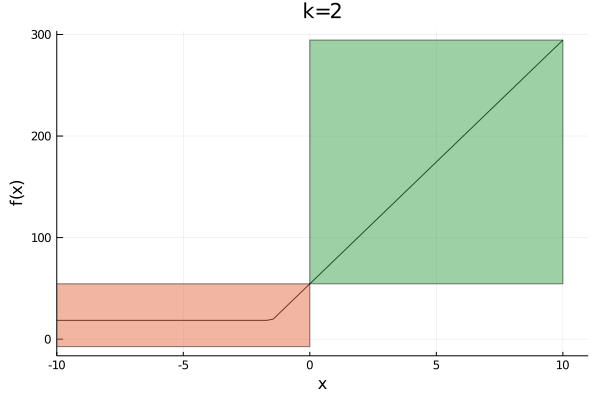

In [10]:
k = 2
xin = split(Interval(-10, 10), [k])
xout = [forward_propagate(small_nnet, x) for x in xin]
plot!(deepcopy(fig), [xi × xo for (xi, xo) in zip(xin, xout)], title="k=$k")

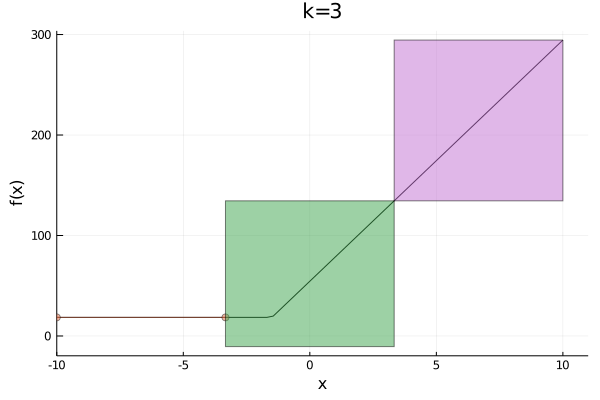

In [11]:
k = 3
xin = split(Interval(-10, 10), [k])
xout = [forward_propagate(small_nnet, x) for x in xin]
plot!(deepcopy(fig), [xi × xo for (xi, xo) in zip(xin, xout)], title="k=$k")

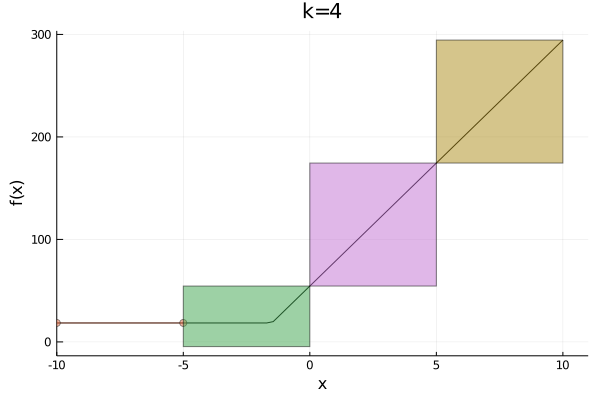

In [12]:
k = 4
xin = split(Interval(-10, 10), [k])
xout = [forward_propagate(small_nnet, x) for x in xin]
plot!(deepcopy(fig), [xi × xo for (xi, xo) in zip(xin, xout)], title="k=$k")

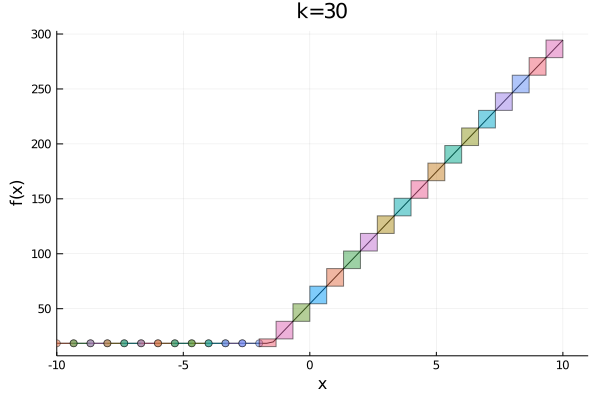

In [13]:
k = 30
xin = split(Interval(-10, 10), [k])
xout = [forward_propagate(small_nnet, x) for x in xin]
plot!(deepcopy(fig), [xi × xo for (xi, xo) in zip(xin, xout)], title="k=$k")

## Backprop

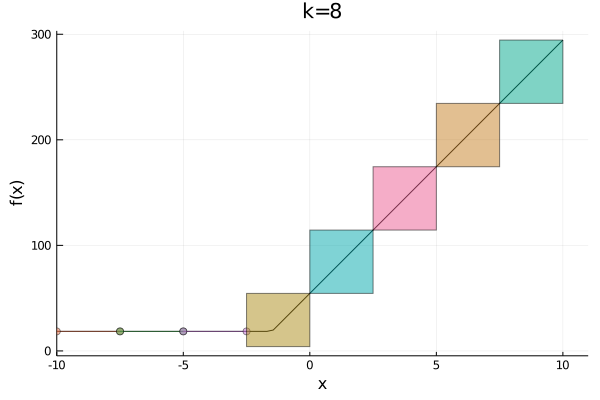

In [14]:
k = 8
xin = split(Interval(-10, 10), [k])
xout = [forward_propagate(small_nnet, x) for x in xin]
plot!(deepcopy(fig), [xi × xo for (xi, xo) in zip(xin, xout)], title="k=$k")

Suppose that we take the output `xout[6]` and we would like to idenfity `xin[6]`.

In [15]:
yout = convert(Interval, xout[6])

Interval{Float64,IntervalArithmetic.Interval{Float64}}([114.5, 174.5])

In [16]:
yin = convert(Interval, xin[6])

Interval{Float64,IntervalArithmetic.Interval{Float64}}([2.5, 5])

1) Describe the set `wout` such that `relu(X) = yout`.

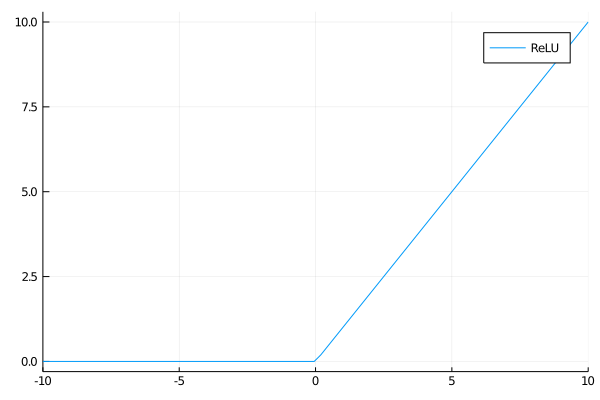

In [17]:
plot(x -> max(x, 0), xlims=(-10, 10), lab="ReLU")

In this case that set is again `yout`.

In [18]:
wout = copy(yout)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([114.5, 174.5])

2) Describe the set `wout′` such that `wout = W3 * wout′ + b3`.

In [19]:
W3 = small_nnet.layers[3].weights
b3 = small_nnet.layers[3].bias;

In [20]:
W3

1×2 Array{Float64,2}:
 3.0  3.0

In [21]:
b3

1-element Array{Float64,1}:
 3.5

In [22]:
# wout = 3*wout′[1] + 3*wout′[2] + 3.5

In [23]:
using ModelingToolkit
var = @variables x y

(x, y)

In [24]:
L1 = Hyperplane(min(wout) == 3*x + 3*y + 3.5, var)

Hyperplane{Float64,Array{Float64,1}}([-3.0, -3.0], -111.0)

In [25]:
L2 = Hyperplane(max(wout) == 3*x + 3*y + 3.5, var)

Hyperplane{Float64,Array{Float64,1}}([-3.0, -3.0], -171.0)

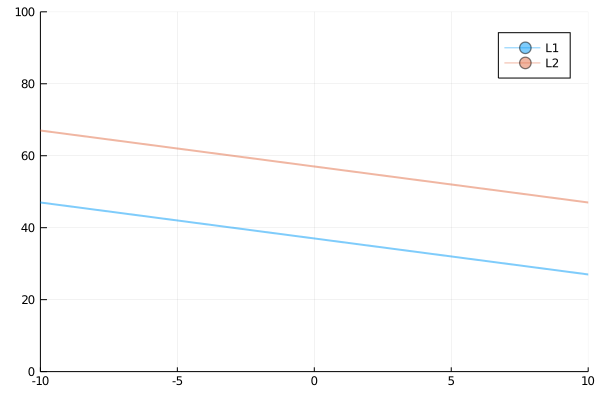

In [26]:
plot(L1, xlims=(-10.0, 10.0), ylims=(0.0, 100.0), lab="L1", lw=2.0)
plot!(L2, xlims=(-10.0, 10.0), ylims=(0.0, 100.0), lab="L2", lw=2.0)

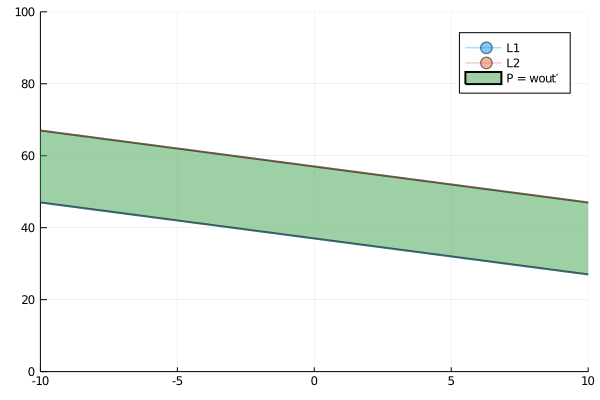

In [27]:
P = HPolyhedron([3*x + 3*y + 3.5 >= min(wout),  
                 3*x + 3*y + 3.5 <= max(wout)], var)

plot(L1, xlims=(-10.0, 10.0), ylims=(0.0, 100.0), lab="L1", lw=2.0)
plot!(L2, xlims=(-10.0, 10.0), ylims=(0.0, 100.0), lab="L2", lw=2.0)

plot!(P, xlims=(-10.0, 10.0), ylims=(0.0, 100.0), lab="P = wout′", lw=2.0)

In [28]:
wout′ = P

HPolyhedron{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([-3.0, -3.0], -111.0), HalfSpace{Float64,Array{Float64,1}}([3.0, 3.0], 171.0)])

We can check that `wout′` is the set we were looking for:

In [29]:
overapproximate(W3 * wout′ + b3, Interval)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([114.5, 174.5])

In [30]:
wout

Interval{Float64,IntervalArithmetic.Interval{Float64}}([114.5, 174.5])

3) Describe the set `qout` such that `relu(qout) = wout′`.

First we intesect `wout′` with the positive quadrant.

In [31]:
wout′

HPolyhedron{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([-3.0, -3.0], -111.0), HalfSpace{Float64,Array{Float64,1}}([3.0, 3.0], 171.0)])

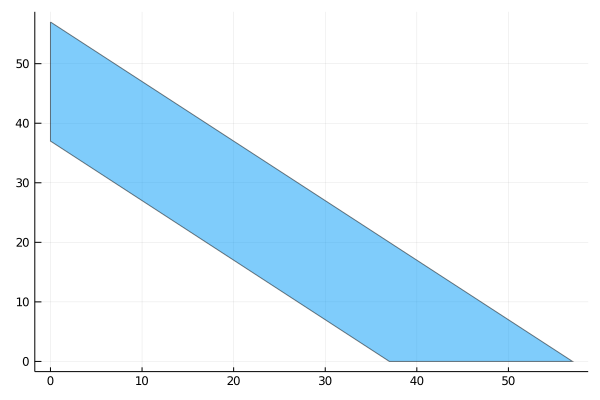

In [32]:
max_wout′_x = 1000.0
max_wout′_y = 1000.0
K = intersection(wout′, Hyperrectangle(low=[0.0, 0.0], high=[max_wout′_x, max_wout′_y]))
plot(K)

In [33]:
W2 = small_nnet.layers[2].weights
b2 = small_nnet.layers[2].bias;
W2

2×2 Array{Float64,2}:
 2.0  2.0
 2.0  2.0